# 用户消费行为分析

## 1.数据预处理

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
# 更改设计风格
plt.style.use('ggplot')
columns = ['user_id','order_dt','order_products','order_amount']
df = pd.read_table('CDNOW.txt',names=columns,sep='\s+')

F:\anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: read_table is deprecated, use read_csv instead.
  


In [83]:
df.head()

,user_id,order_dt,order_products,order_amount
0,1,19970101,1,11.77
1,2,19970112,1,12.00
2,2,19970112,5,77.00
3,3,19970102,2,20.76
4,3,19970330,2,20.76


In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69659 entries, 0 to 69658
Data columns (total 4 columns):
user_id           69659 non-null int64
order_dt          69659 non-null int64
order_products    69659 non-null int64
order_amount      69659 non-null float64
dtypes: float64(1), int64(3)
memory usage: 2.1 MB


In [85]:
#数据类型转换
df['order_dt'] = pd.to_datetime(df.order_dt,format="%Y%m%d")
df['month'] = df.order_dt.values.astype('datetime64[M]')
df.head()

,user_id,order_dt,order_products,order_amount,month
0,1,1997-01-01,1,11.77,1997-01-01
1,2,1997-01-12,1,12.00,1997-01-01
2,2,1997-01-12,5,77.00,1997-01-01
3,3,1997-01-02,2,20.76,1997-01-01
4,3,1997-03-30,2,20.76,1997-03-01


In [86]:
df.describe()

,user_id,order_products,order_amount
count,69659.000000,69659.000000,69659.000000
mean,11470.854592,2.410040,35.893648
std,6819.904848,2.333924,36.281942
min,1.000000,1.000000,0.000000
25%,5506.000000,1.000000,14.490000
50%,11410.000000,2.000000,25.980000
75%,17273.000000,3.000000,43.700000
max,23570.000000,99.000000,1286.010000


大部分订单只消费了少量商品（平均2.4），有一定极值干扰。
用户消费金额比较稳定，平均消费35.89元，中位数是25.98，有一定极值干扰。

## 2. 进行用户消费趋势的分析（按月）
### 2.1 每月的消费总金额

In [87]:
grouped_month = df.groupby(by='month')
order_month_amount = grouped_month.order_amount.sum()
order_month_amount.head()

month
1997-01-01    299060.17
1997-02-01    379590.03
1997-03-01    393155.27
1997-04-01    142824.49
1997-05-01    107933.30
Name: order_amount, dtype: float64

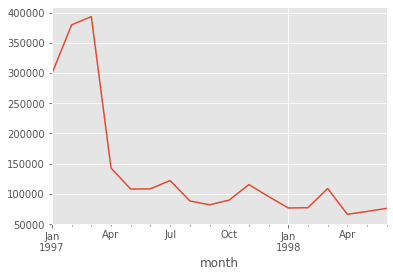

In [88]:
order_month_amount.plot()

由上图可知，消费金额在前三个月达到最高峰，后续消费较为稳定，有轻微下降趋势。

### 2.2 每月的消费订单数

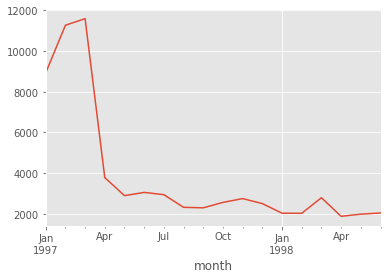

In [89]:
comsume_month_count = grouped_month.user_id.count().plot()

前三个月消费订单数在10000笔左右，后续月份的平均消费订单数则在2500左右。

### 2.3 每月的产品购买量

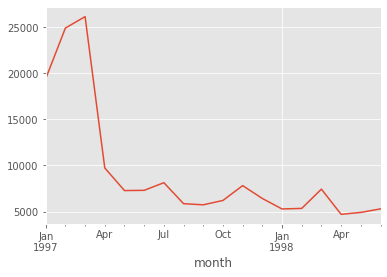

In [90]:
grouped_month.order_products.sum().plot()

每月的产品购买量一样呈现早期购买量多，后期平稳下降的趋势。

### 2.4 每月的消费人数

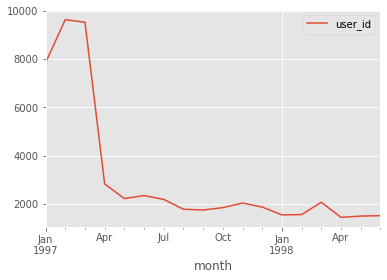

In [91]:
user_month = df.groupby('month').user_id.apply(lambda x:len(x.drop_duplicates()))
#user_month.plot()
groupby_user = df.groupby(['month','user_id']).count().reset_index()[['month','user_id']]
groupby_user.groupby('month').count().plot()

每月消费人数低于每月消费次数，但差异不大；
前三个月每月的消费人数在8000-10000之间，后续月份平均消费人数2000不到

### 2.5 数据透视

In [92]:
df.pivot_table(index = 'month',
               values = ['order_products','order_amount','user_id'],
               aggfunc = {'order_products':'sum',
                          'order_amount':'sum',
                          'user_id':'count'}).head()

,order_amount,order_products,user_id
month,,,
1997-01-01,299060.17,19416,8928
1997-02-01,379590.03,24921,11272
1997-03-01,393155.27,26159,11598
1997-04-01,142824.49,9729,3781
1997-05-01,107933.30,7275,2895


### 2.6 每月用户平均消费金额的趋势

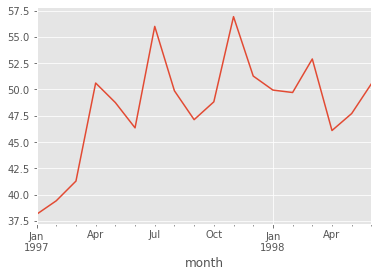

In [93]:
avg_month_amount = order_month_amount/user_month
avg_month_amount.plot()

## 3. 用户个体消费分析
### 3.1 用户消费金额、消费次数的描述统计

In [94]:
grouped_user = df.groupby(by='user_id')
grouped_user.sum().describe()

,order_products,order_amount
count,23570.000000,23570.000000
mean,7.122656,106.080426
std,16.983531,240.925195
min,1.000000,0.000000
25%,1.000000,19.970000
50%,3.000000,43.395000
75%,7.000000,106.475000
max,1033.000000,13990.930000


从用户角度看，每位用户平均购买7张CD，最多购买了1033张。用户的平均消费金额（客单价）106元，标准差是240，结合分位数和最大值看，平均值和75分位接近，肯定存在小部分的高额消费用户。
用户平均消费106元，中位数只有43，判断同上，有极值干扰。

### 3.2 用户消费金额和消费次数的散点图

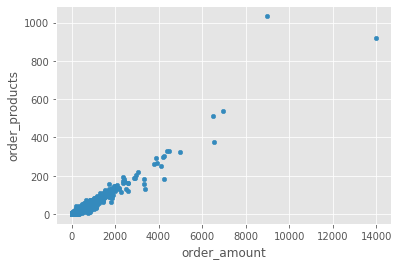

In [95]:
grouped_user.sum().plot.scatter(x='order_amount',y='order_products')

受少数极值影响，散点图下方大部分点堆积在一起。同时我们可以看到大部分点横坐标是小于4000的，所以我们可以做一个筛选。

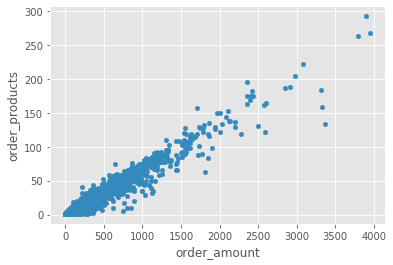

In [96]:
grouped_user.sum().query('order_amount<4000').plot.scatter(x='order_amount',y='order_products')

每个用户购买CD的次数和金额呈现强烈的正比关系。这很容易理解，CD的单价波动范围较小。上图反应了商品单价，如果商品种类丰富，单价范围较广，可能会呈现扇形扩散形状。

### 3.3 用户消费金额的分布图

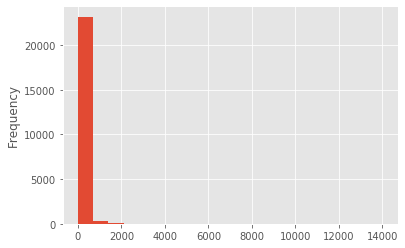

In [97]:
grouped_user.sum().order_amount.plot.hist(bins=20)

从直方图可知，用户消费金额绝大部分呈现集中趋势，小部分异常值干扰了判断。可以使用过滤操作排除异常。

### 3.4 用户消费次数的分布图

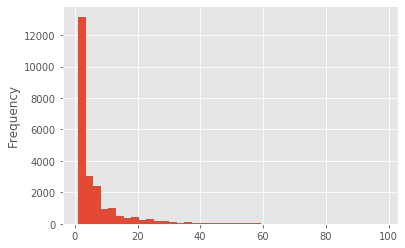

In [98]:
grouped_user.sum().query('order_products<100').order_products.plot.hist(bins=40)

潜意识：消费相关的数据，基本上都是这种类型的数据分布。小部分用户消费金额占大头。
使用切比雪夫定理过滤掉异常值，计算95%的数据的分布情况。如上面购买产品数<100是如何确定的，均值7+标准差17*5=92

### 3.5 用户累计消费金额占比（百分之多少的用户占了百分之多少的消费额）

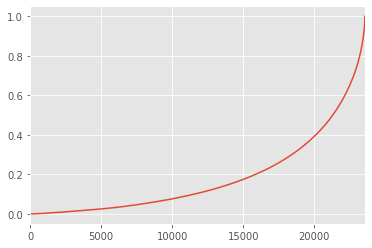

In [99]:
#cumsum滚动累加求和
user_cumsum = grouped_user.sum().sort_values('order_amount').apply(lambda x:x.cumsum()/x.sum())
user_cumsum.reset_index().order_amount.plot()

前20000名用户贡献了40%的消费，而后3500名用户贡献了60%的消费。符合二八趋势。也就是说我们只要维护了这3500个用户就可以把业绩KPI完成60%，如果能把3500个用户运营的更好就可以占比70%—80%之间。

### 4. 用户消费行为

### 4.1 用户第一次消费（首购）

在很多行业里面首购是一个很重要的维度，它和渠道息息相关，尤其是针对客单价比较高客户留存率比价低的行业，第一次客户从哪里来可以拓展出很多运营方式。

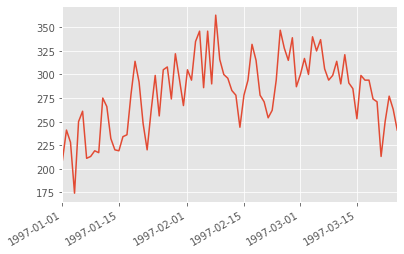

In [100]:
#求月份的最小值，即用户消费行为中的第一次消费时间
grouped_user.min().order_dt.value_counts().plot()

用户第一次购买分布，集中在前三个月。其中，在2月11日至2月25日有一次剧烈的波动。
具体原因可以做假设，比如渠道发生了变化，比如奖励激励的方式发生了变化，还比如2月份可能和春节相关，但国外没有春节，可以排除掉。

### 4.2 用户最后一次消费

用户最后一次消费和流失相关

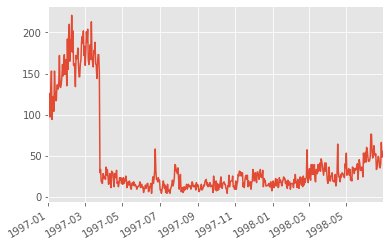

In [101]:
grouped_user.max().order_dt.value_counts().plot()

有明显的断崖式下跌，前面3个月新用户来的比较多，后面几个月没有新增，主要是老客户（熟客）的消费，从侧面说明绝大部分用户只消费了一次就不再消费。
用户最后一次购买的分布比第一次分布广，大部分最后一次购买集中在前三个月，说明有很多用户购买了一次后就不再进行购买。随着时间的递增，最后一次购买数也在递增，消费呈现流失上升的状况，用户忠诚度在慢慢下降。

### 4.3 新老客消费比（多少用户仅消费了一次）

In [102]:
user_life = grouped_user.order_dt.agg(['min','max'])
user_life.head()

,min,max
user_id,,
1,1997-01-01,1997-01-01
2,1997-01-12,1997-01-12
3,1997-01-02,1998-05-28
4,1997-01-01,1997-12-12
5,1997-01-01,1998-01-03


In [103]:
(user_life['min'] == user_life['max']).value_counts()

True     12054
False    11516
dtype: int64

有超过一般的用户仅消费一次，这也说明了运营不好，留存效果不好。

### 4.4 用户分层
#### 4.4.1 RFM

RFM模型通过一个客户的近期购买行为、购买的总体频率以及花了多少钱3项指标来描述该客户的价值状况。

最近一次消费 (Recency)

消费频率 (Frequency)  F值越大，表示客户交易越频繁，反之则表示客户交易不够活跃。

消费金额 (Monetary)   M值越大，表示客户价值越高，反之则表示客户价值越低。

In [104]:
rfm = df.pivot_table(index = 'user_id',
                     values = ['order_products','order_amount','order_dt'],
                     aggfunc = {'order_dt':'max',
                                'order_amount':'sum',
                                'order_products':'sum'})
rfm.head()
#order_amount消费总金额，order_products消费总产品数，order_dt最近一次消费时间

,order_amount,order_dt,order_products
user_id,,,
1,11.77,1997-01-01,1
2,89.00,1997-01-12,6
3,156.46,1998-05-28,16
4,100.50,1997-12-12,7
5,385.61,1998-01-03,29


In [105]:
rfm['R']=(rfm.order_dt.max()-rfm.order_dt)/np.timedelta64(1,'D')  #除以单位，变成数值
rfm.rename(columns = {'order_products':'F','order_amount':'M'},inplace = True)
rfm.head()

,M,order_dt,F,R
user_id,,,,
1,11.77,1997-01-01,1,545.0
2,89.00,1997-01-12,6,534.0
3,156.46,1998-05-28,16,33.0
4,100.50,1997-12-12,7,200.0
5,385.61,1998-01-03,29,178.0


In [106]:
#将RFM区分为不同维度，高于均值，低于均值
rfm[['R','F','M']].apply(lambda x:x-x.mean()).head()

,R,F,M
user_id,,,
1,177.778362,-6.122656,-94.310426
2,166.778362,-1.122656,-17.080426
3,-334.221638,8.877344,50.379574
4,-167.221638,-0.122656,-5.580426
5,-189.221638,21.877344,279.529574


In [107]:
def rfm_func(x):
    level = x.apply(lambda x:'1' if x>=0 else '0')
    label = level.R + level.F + level.M
    d = {
         '111':'重要价值客户',
         '011':'重要保持客户',
         '101':'重要挽留客户',
         '001':'重要发展客户',
         '110':'一般价值客户',
         '010':'一般保持客户',
         '100':'一般挽留客户',
         '000':'一般发展客户'
    }
    result = d[label]
    return result

rfm['label'] = rfm[['R','F','M']].apply(lambda x:x-x.mean()).apply(rfm_func,axis=1)
rfm

,M,order_dt,F,R,label
user_id,,,,,
1,11.77,1997-01-01,1,545.0,一般挽留客户
2,89.00,1997-01-12,6,534.0,一般挽留客户
3,156.46,1998-05-28,16,33.0,重要保持客户
4,100.50,1997-12-12,7,200.0,一般发展客户
5,385.61,1998-01-03,29,178.0,重要保持客户
6,20.99,1997-01-01,1,545.0,一般挽留客户
7,264.67,1998-03-22,18,100.0,重要保持客户
8,197.66,1998-03-29,18,93.0,重要保持客户
9,95.85,1998-06-08,6,22.0,一般发展客户


In [108]:
rfm.groupby('label').count()

,M,order_dt,F,R
label,,,,
一般价值客户,77,77,77,77
一般保持客户,206,206,206,206
一般发展客户,3300,3300,3300,3300
一般挽留客户,14074,14074,14074,14074
重要价值客户,787,787,787,787
重要保持客户,4554,4554,4554,4554
重要发展客户,331,331,331,331
重要挽留客户,241,241,241,241


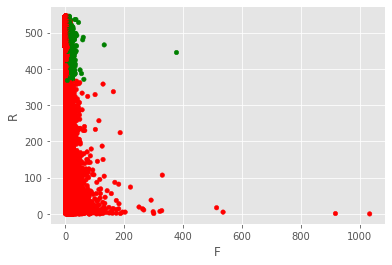

In [109]:
rfm.loc[rfm.label == '重要价值客户','color'] = 'g'
rfm.loc[~(rfm.label == '重要价值客户'),'color'] = 'r'
rfm.plot.scatter('F','R',c=rfm.color)

In [110]:
rfm.groupby('label').sum()

,M,F,R
label,,,
一般价值客户,7181.28,650,36295.0
一般保持客户,19937.45,1712,29448.0
一般发展客户,196971.23,13977,591108.0
一般挽留客户,438291.81,29346,6951815.0
重要价值客户,167080.83,11121,358363.0
重要保持客户,1592039.62,107789,517267.0
重要发展客户,45785.01,2023,56636.0
重要挽留客户,33028.40,1263,114482.0


从RFM分层可知，大部分用户为重要保持客户，但是这是由于极值的影响，所以RFM的划分标准应该以业务为准

尽量用小部分的用户覆盖大部分的额度

不要为了数据好看划分等级

#### 4.4.2 用户生命周期（新、老、活跃、回流、流失）

In [165]:
pivoted_counts = df.pivot_table(index = 'user_id',
                                columns = 'month',
                                values = 'order_dt',
                                aggfunc = 'count').fillna(0)
columns_month=df['month'].sort_values().astype('str').unique()
pivoted_counts.columns=columns_month
pivoted_counts.head()

,1997-01-01,1997-02-01,1997-03-01,1997-04-01,1997-05-01,1997-06-01,1997-07-01,1997-08-01,1997-09-01,1997-10-01,1997-11-01,1997-12-01,1998-01-01,1998-02-01,1998-03-01,1998-04-01,1998-05-01,1998-06-01
user_id,,,,,,,,,,,,,,,,,,
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0


生命周期的划分只需要知道用户本月是否消费，消费次数在这里并不重要，需要将模型进行简化
有些用户在某月没有进行过消费，会用NaA表示，这里用filna填充。

In [166]:
df_purchase = pivoted_counts.applymap(lambda x: 1 if x>0 else 0)
df_purchase.tail()

,1997-01-01,1997-02-01,1997-03-01,1997-04-01,1997-05-01,1997-06-01,1997-07-01,1997-08-01,1997-09-01,1997-10-01,1997-11-01,1997-12-01,1998-01-01,1998-02-01,1998-03-01,1998-04-01,1998-05-01,1998-06-01
user_id,,,,,,,,,,,,,,,,,,
23566,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23567,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23568,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23569,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23570,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


对于尾部数据，user_id2W+的数据是有问题的，因为从实际的业务场景上说，他们一月和二月都没有注册三月份才是他们第一次消费。透视会把他们一月和二月的数据补上为0，这里面需要进行判断将第一次消费作为生命周期的起始，不能从一月份开始就粗略的计算。

In [167]:
def active_status(data):
    status = []
    for i in range(18):
        
        #若本月没有消费
        if data[i] == 0:
            if len(status) > 0:
                if status[i-1] == 'unreg':
                    status.append('unreg')
                else:
                    status.append('unactive')
            else:
                status.append('unreg')
                
        #若本月消费
        else:
            if len(status) == 0:
                status.append('new')
            else:
                if status[i-1] == 'unactive':
                    status.append('return')
                elif status[i-1] == 'unreg':
                    status.append('new')
                else:
                    status.append('active')
    return pd.Series(status, index = df_purchase.columns)


主要分为两部分的判断，以本月是否消费为界。

若本月没有消费：

若之前是未注册，则依旧为未注册；
若之前有消费，则为流失/不活跃；
其他情况，为未注册；

若本月有消费：

若是第一次消费，则为新用户；
若之前有过消费，且上个月为不活跃，则为回流；
若上个月为未注册，则为新用户；
除此之前，为活跃。

这里用户生命周期的状态变化是用数据透视表一次性做的，但在实际业务场景中我们可能用SQL把它作为中间表来处理。我们有了明细表，会通过明细表来计算出状态表；也就是它的数据上个月是什么样的情况得出来，比如上个月是新用户或者回流用户，我们直接用上个月的状态left join本月的状态。直接用SQL进行对比。
可以用pandas将每个月的状态计算出来，不是逐行而是月份计算，先算出一月份哪些用户是新购买的，然后判断二月份是否购买，两者left join。


In [168]:
purchase_status = df_purchase.apply(active_status,axis = 1)
purchase_status.tail()

,1997-01-01,1997-02-01,1997-03-01,1997-04-01,1997-05-01,1997-06-01,1997-07-01,1997-08-01,1997-09-01,1997-10-01,1997-11-01,1997-12-01,1998-01-01,1998-02-01,1998-03-01,1998-04-01,1998-05-01,1998-06-01
user_id,,,,,,,,,,,,,,,,,,
23566,unreg,unreg,new,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive
23567,unreg,unreg,new,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive
23568,unreg,unreg,new,active,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive
23569,unreg,unreg,new,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive
23570,unreg,unreg,new,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive


In [169]:
#每月不同活跃用户的计数
purchase_status_ct = purchase_status.replace('unreg',np.NaN).apply(lambda x:pd.value_counts(x))
purchase_status_ct


,1997-01-01,1997-02-01,1997-03-01,1997-04-01,1997-05-01,1997-06-01,1997-07-01,1997-08-01,1997-09-01,1997-10-01,1997-11-01,1997-12-01,1998-01-01,1998-02-01,1998-03-01,1998-04-01,1998-05-01,1998-06-01
active,NaN,1157.0,1681,1773.0,852.0,747.0,746.0,604.0,528.0,532.0,624.0,632.0,512.0,472.0,571.0,518.0,459.0,446.0
new,7846.0,8476.0,7248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
return,NaN,NaN,595,1049.0,1362.0,1592.0,1434.0,1168.0,1211.0,1307.0,1404.0,1232.0,1025.0,1079.0,1489.0,919.0,1029.0,1060.0
unactive,NaN,6689.0,14046,20748.0,21356.0,21231.0,21390.0,21798.0,21831.0,21731.0,21542.0,21706.0,22033.0,22019.0,21510.0,22133.0,22082.0,22064.0


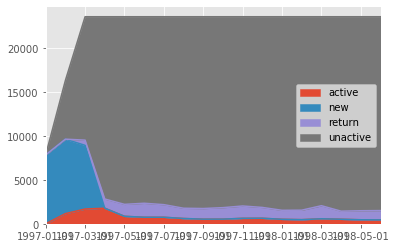

In [170]:
purchase_status_ct.fillna(0).T.head()
purchase_status_ct.fillna(0).T.plot.area()


In [171]:
purchase_status_ct.fillna(0).T.apply(lambda x:x/x.sum(),axis=1)


,active,new,return,unactive
1997-01-01,0.000000,1.000000,0.000000,0.000000
1997-02-01,0.070886,0.519299,0.000000,0.409815
1997-03-01,0.071319,0.307510,0.025244,0.595927
1997-04-01,0.075223,0.000000,0.044506,0.880272
1997-05-01,0.036148,0.000000,0.057785,0.906067
1997-06-01,0.031693,0.000000,0.067543,0.900764
1997-07-01,0.031650,0.000000,0.060840,0.907510
1997-08-01,0.025626,0.000000,0.049555,0.924820
1997-09-01,0.022401,0.000000,0.051379,0.926220
1997-10-01,0.022571,0.000000,0.055452,0.921977


由上表可知，每月的用户消费状态变化：

- 新客用户：仅在前三个月，后续再无新增客户。

- 活跃用户：比例持续下降，说明持续消费的用户数量在减少，也说明运营部门的促活效果并不好。

- 回流用户：比例也稍有下降，在4%左右波动。

- 不活跃用户：比例稍有上升，流失较大。

### 4.5 用户购买周期（按订单）

#### 4.5.1 用户消费周期描述

In [172]:
order_diff = grouped_user.apply(lambda x:x.order_dt - x.order_dt.shift())
order_diff.head(10)
#将用户分组后，每个用户的订单购买时间进行错位相减

user_id   
1        0        NaT
2        1        NaT
         2     0 days
3        3        NaT
         4    87 days
         5     3 days
         6   227 days
         7    10 days
         8   184 days
4        9        NaT
Name: order_dt, dtype: timedelta64[ns]

In [173]:
order_diff.describe()

count                      46089
mean     68 days 23:22:13.567662
std      91 days 00:47:33.924168
min              0 days 00:00:00
25%             10 days 00:00:00
50%             31 days 00:00:00
75%             89 days 00:00:00
max            533 days 00:00:00
Name: order_dt, dtype: object

#### 4.5.2 用户消费周期分布

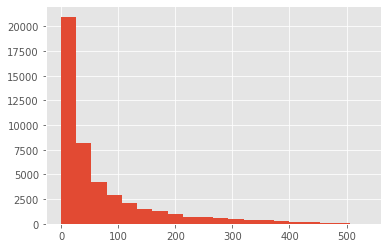

In [174]:
(order_diff / np.timedelta64(1,'D')).hist(bins=20)

- 订单周期呈指数分布
- 用户的平均购买周期是68天
- 绝大部分用户的购买周期都低于100天

### 4.6 用户生命周期（按第一次&最后一次消费）

#### 4.6.1 用户生命周期描述

In [175]:
(user_life['max'] - user_life['min']).describe()

count                       23570
mean     134 days 20:55:36.987696
std      180 days 13:46:43.039788
min               0 days 00:00:00
25%               0 days 00:00:00
50%               0 days 00:00:00
75%             294 days 00:00:00
max             544 days 00:00:00
dtype: object

数据偏移比较大，中位数是0天也就是超过50%的用户生命周期是0天只购买了一次，但是平均生命周期有134天，最大值是544天。

#### 4.6.2 用户生命周期分布

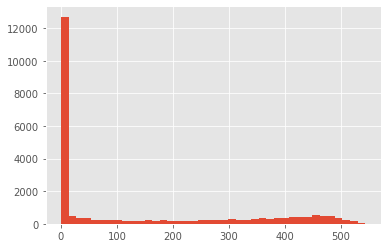

In [176]:
((user_life['max'] - user_life['min']) / np.timedelta64(1,'D')).hist(bins=40)

- 用户的生命周期受只购买一次的用户影响比较厉害（可以排除）
- 用户均消费134天，中位数仅0天

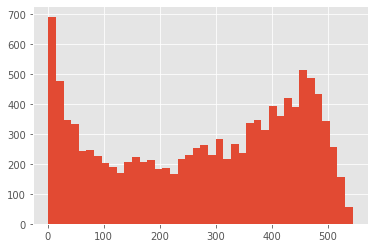

In [177]:
#过滤只购买一次的用户
u_1 = ((user_life['max'] - user_life['min']).reset_index()[0] / np.timedelta64(1,'D'))
u_1[u_1 > 0].hist(bins = 40)

上图可见，用户生命周期呈现双峰趋势，20天内生命周期的用户是一个高峰，400至500天内生命周期的用户是另一个高峰。

根据此情况，应该在20天内对客户进行引导，促进其再次消费并形成消费习惯，延长其生命周期；在100至400天的用户，也要根据其特点推出有针对性的营销活动，引导其持续消费。

分析去掉0天生命周期的用户之后的用户生命周期的平均值。


### 5. 复购率和回购率分析

复购率：自然月内，购买多次的用户占比

回购率：曾经购买过的用户在某一时期内的再次购买占比

In [178]:
pivoted_counts.head()

,1997-01-01,1997-02-01,1997-03-01,1997-04-01,1997-05-01,1997-06-01,1997-07-01,1997-08-01,1997-09-01,1997-10-01,1997-11-01,1997-12-01,1998-01-01,1998-02-01,1998-03-01,1998-04-01,1998-05-01,1998-06-01
user_id,,,,,,,,,,,,,,,,,,
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0


In [179]:
purchase_r = pivoted_counts.applymap(lambda x: 1 if x > 1 else np.NaN if x==0 else 0)
purchase_r.head()

,1997-01-01,1997-02-01,1997-03-01,1997-04-01,1997-05-01,1997-06-01,1997-07-01,1997-08-01,1997-09-01,1997-10-01,1997-11-01,1997-12-01,1998-01-01,1998-02-01,1998-03-01,1998-04-01,1998-05-01,1998-06-01
user_id,,,,,,,,,,,,,,,,,,
1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN
4,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
5,1.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN


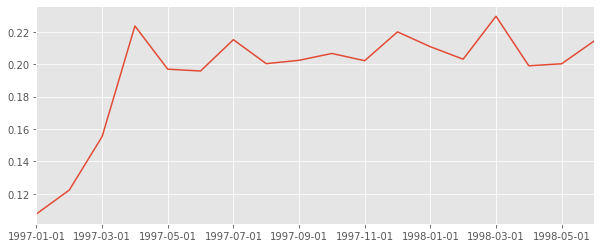

In [180]:
(purchase_r.sum() / purchase_r.count()).plot(figsize = (10,4))


图上可以看出复购率在早期，因为大量新用户加入的关系，新客的复购率并不高，如1月新客们的复购率只有6%左右。而在后期，这时的用户都是大浪淘沙剩下的老客，复购率比较稳定，在20%左右。单看新客和老客，复购率有三倍左右的差距。

### 5.2 回购率

回购率是某一个时间窗口内消费的用户，在下一个时间窗口仍旧消费的占比。如1月消费用户1000，他们中有300个2月依然消费，回购率是30%。

In [181]:
df_purchase.head()

,1997-01-01,1997-02-01,1997-03-01,1997-04-01,1997-05-01,1997-06-01,1997-07-01,1997-08-01,1997-09-01,1997-10-01,1997-11-01,1997-12-01,1998-01-01,1998-02-01,1998-03-01,1998-04-01,1998-05-01,1998-06-01
user_id,,,,,,,,,,,,,,,,,,
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
5,1,1,0,1,1,1,1,0,1,0,0,1,1,0,0,0,0,0


In [183]:
#如果本月进行消费，下月也进行消费，则记为1；如果下月没有消费，
# 则记为0，若本月没有记为消费，则记为nan
def purchase_back(data):
    status=[]
    for i in range(17):#循环17个月
        if data[i]==1:#若本月消费
            if data[i+1]==1:#下个月也消费
                status.append(1)#就记为1
            if data[i+1]==0:#下个月不消费，就记为0
                status.append(0)
        else:
            status.append(np.nan)
    status.append(np.nan)
    return pd.Series(status,index=columns_month)

In [184]:
purchase_b = df_purchase.apply(purchase_back,axis=1)
purchase_b.head()

,1997-01-01,1997-02-01,1997-03-01,1997-04-01,1997-05-01,1997-06-01,1997-07-01,1997-08-01,1997-09-01,1997-10-01,1997-11-01,1997-12-01,1998-01-01,1998-02-01,1998-03-01,1998-04-01,1998-05-01,1998-06-01
user_id,,,,,,,,,,,,,,,,,,
1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN
4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
5,1.0,0.0,NaN,1.0,1.0,1.0,0.0,NaN,0.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN


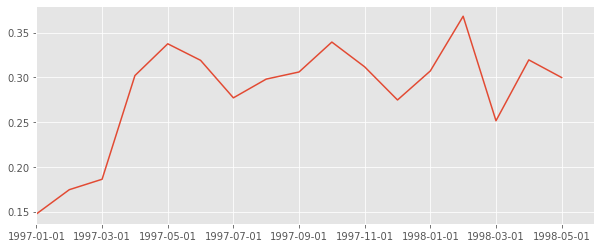

In [185]:
(purchase_b.sum() / purchase_b.count()).plot(figsize = (10,4))

- 上图可以看出，在初期用户的回购率并不高，1月的回购率只有15%左右，4月份起回购率稳定在30%左右。

- 从每月有回购消费的用户数数据可以看出，回购用户数整体有下降趋势。

- 对回购率的分析，再次说明了对于新用户，在其第一次消费后的三个月内是一段重要的时期，需要营销策略积极引导其再次消费及持续消费。

- 另外，对于有持续消费的老客，也要适时推出反馈老客户的优惠活动，以加强老客的忠诚度。

## 结论

1.整体趋势：按年的月份趋势销量和销售额在1-3月份相对极高，然后骤降，原因应该与促销有关，但总体上呈现大幅下降趋势，应该要考虑市场变化、或者是客户需求的改变。

2.用户个体特征：大多数用户都是小金额批量购买，那么能否添加一些促销活动(如团购、满送、满减等)，促进客户销售。

3.大部分用户的消费总额和购买总量都集中在低段，长尾分布，那能够构建用户画像，了解群体，针对群体性进行相应的促销活动或者是为CD赋予文娱元素。

4.用户的消费周期：有二次以上消费的用户，平均68天，所以在50天到60天期间，应该对这批用户进行刺激召回，细致点，比如10天回复满意度，30天发放优惠券，55天的时候提醒优惠券的使用。

5.用户的生命周期：有二次及以上消费的用户的平均生命周期是276天。用户的生命周期分别在20天内与400至500天间，应该在20天内对客户进行引导，促进其再次消费并形成消费习惯，延长其生命周期；在100至400天的用户，也要根据其特点推出有针对性的营销活动，引导其持续消费。

6..新客户的复购率约为6%，老客户的复购率在20%左右；新客户的回购率在15%左右，老客户的回购率在30%左右，在这里，我们就需要进一步查看，为什么新客户的复购率会低，客户群体的原因？还是部分群体特征都存在这种情况，那么此时应该就要考虑我们产品了？是我们的产品不符合所有新客户期待吗？对于老客户的复购率，是否能够提高？老客户复购的产品是什么类型的？是否增加丰富度？等等。。这些探索都是为了理解我们的客户，为客户提供更多关怀，提高客户忠诚度。

7.用户质量：用户个体消费有一定规律性，大部分用户的消费集中在2000以下，用户消费反应了2/8法则，消费排名前20%的用户贡献了80%的消费额。所以说，狠抓高质量用户是万古不变的道理，这些高质量客户都是“会员”类型，需要专门为会员优化购物体验，比如专线接听、特殊优惠等等。而对于长尾客户，我们是不能放弃的，比如说，当前客户仅购买一种类别的音乐，那么能否让客户在我们这里购买其他类别的音乐产品。